In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (32, 320) # (w, h)

import numpy as np
import urllib.request as request
import cv2
import timeit

In [2]:
#image_bytes = urllib.urlopen("https://upload.wikimedia.org/wikipedia/en/1/1e/Gorasara_Son_flower_Farms.jpeg").read()
img_data = request.urlopen("https://lh3.googleusercontent.com/proxy/t2s-7OD8li3APf0Bq65o6bsao6GO6LkjIl7PlssZnKnXweaWHj4QKSe9OxRXpzNvikreoGNGbIwAre4NcLnY7Y-PzdLjnQ7o1sszfHLT19Rm1JAhi_71").read()
img = cv2.imdecode(np.asarray(bytearray(img_data), dtype=np.uint8), -1) /255.

In [3]:
def show(img):
    if type(img)==list:
        img = np.concatenate(img, axis=1)
    if len(img.shape) == 2:
        plt.imshow((img * 255).astype(np.uint8), cmap="gray")
    else:
        plt.imshow(cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))


## Box Filter

Box filter is replacing every pixel with the mean of the neighborhood around it.

Can be implemented as a convolution as well.

For a filter size = **fxf** pixels and an image size of **nxn** pixels, the complexity of the operation on the naive version is ** O(f^2*n^2) **.

In [4]:
def box_filter_loop(img, box_width, box_height):
    surface = box_width * box_height
    response = np.zeros_like(img[:-(box_height-1),:-(box_width-1)])
    for region_left in range(1+img.shape[1]-box_width):
        for region_top in range(1+img.shape[0]-box_height):
            local_sum = 0
            for filter_x in range(region_left, region_left + box_width):
                for filter_y in range(region_top, region_top + box_height):
                    local_sum += img[filter_y, filter_x]
            response[region_top, region_left] = local_sum / surface
    return response
            

### This is how we think of the algorithm:


```python
for region_left in range(1+img.shape[1]-box_width):
    for region_top in range(1+img.shape[0]-box_height):
        local_sum = 0
        for filter_x in range(region_left, region_left + box_width):
            for filter_y in range(region_top, region_top + box_height):
                local_sum += img[filter_y, filter_x]
        response[region_top, region_left] = local_sum / surface
```


### Step1: Lets move the image-wide iterations as the inner loops:
```python
offseted_response = np.zeros([1 + img.shape[0] + box_height, 1 + img.shape[1] + box_width])
for filter_x in range(region_left, region_left + box_width):
    for filter_y in range(region_top, region_top + box_height):
        for region_left in range(offseted_response.shape[1]):
            for region_top in range(offseted_response.shape[1]):
                offseted_response[region_top, region_left] += img[region_top+filter_y, region_left+filter_x] 
final_response = offseted_response/surface
```

### Step2: Lets remove the image-wide iterations:
```python
offseted_response = np.zeros([1 + img.shape[0] + box_height, 1 + img.shape[1] + box_width])
for filter_x in range(region_left, region_left + box_width):
    for filter_y in range(region_top, region_top + box_height):
        offseted_response += img[filter_y:filter_y+offseted_response.shape[0],
                                 filter_x:filter_x+offseted_response.shape[1]]    
final_response = offseted_response/surface
```

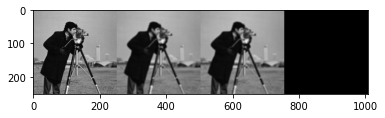

In [5]:
def box_filter_vectorized(img, box_width, box_height):
    surface = box_width * box_height
    response = np.zeros_like(img[:-(box_height-1),:-(box_width-1)])
    response_h, response_w = response.shape
    for local_x in range(box_width):
        for local_y in range(box_height):
            response = response+ img[local_y:(response_h+local_y), local_x:(response_w+local_x)]
    return response/surface


# sanity_check
slow = box_filter_loop(img, 5,5)
fast = box_filter_vectorized(img, 5, 5)
show([img[2:-2,2:-2], slow, fast, (slow-fast)**2])

In [6]:
timeit_ctx =  'from __main__ import ' + ', '.join(globals())
loop_filter_speeds = {}
vectorized_speeds = {}
filter_sizes = [3, 5, 7, 9, 11, 13, 15]
for filter_size in filter_sizes:
    loop_filter_speeds[filter_size]=timeit.Timer(lambda: box_filter_loop(img, filter_size,filter_size)).timeit(number=1)
    vectorized_speeds[filter_size]=timeit.Timer(lambda: box_filter_vectorized(img, filter_size,filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Vectorization Box-filter Speedup by filter size')

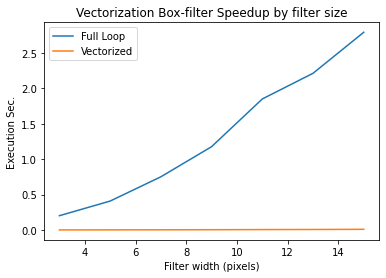

In [7]:
plt.plot(filter_sizes,[[loop_filter_speeds[sz], vectorized_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Full Loop", "Vectorized"])
plt.title("Vectorization Box-filter Speedup by filter size")

### Conclusion 1: Vectorized Performance improves almost exponentially by filter size

In [8]:
loop_speeds = {}
vectorized_speeds = {}
image_sizes = [64, 128, 256, 512, 1024]
filter_size = 3
for img_size in image_sizes:
    rnd_img = np.random.rand(img_size, img_size)
    loop_speeds[img_size]=timeit.Timer(lambda: box_filter_loop(rnd_img, filter_size,filter_size)).timeit(number=1)
    vectorized_speeds[img_size]=timeit.Timer(lambda: box_filter_vectorized(rnd_img, filter_size,filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Vectorization Box-filter Speedup by image size')

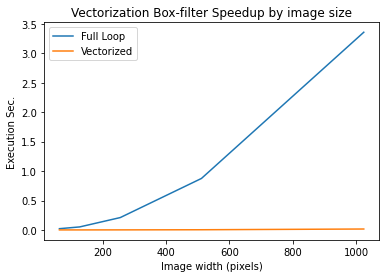

In [9]:
plt.plot(image_sizes,[[loop_speeds[sz], vectorized_speeds[sz]] for sz in image_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Image width (pixels)")
plt.legend(["Full Loop", "Vectorized"])
plt.title("Vectorization Box-filter Speedup by image size")

### Conclusion 2: Vectorized Performance improves almost exponentially by image size as well!

- Have we reduced complexity with vectorization?
    - Not really!

- Lets think complexity wise of two machines: 
    - fortran_O quite efficient.
    - python_O painfully slow.
    - loop Compplexity: ** python_O(f^2*n^2) **.
    - vectorized Compplexity: ** python_O(f^2) * fortran_O(n^2) **

- Further more vectorized code is inherently parallel for the ** fortran_O(n^2) **.
    - Can be computed as multithreaded by just installing the apropriate numpy
    - Can be run on the GPU directly with [Google Jax](https://github.com/google/jax), or converted easilly to [pytorch](https://pytorch.org/) code.

### Can we do better?

- Sure with integral images!
- Integral Image: every pixel contains the sum of all pixels above and to the left.
- We can get the sum of the pixels in any rectangular region by reading only the corners in the integral image.
- Definition: 
```python
int_I = I.cumsum(axis=0).cumsum(axis=1)
```

- Usage: 
```python
I[y1:y2, x1:x2].sum() == (int_I[y1,x1] + int_I[y2,x2]) - (int_I[y2,x1] + int_I[y1,x2])
```
- O(f^2*n^2) => O(n^2)

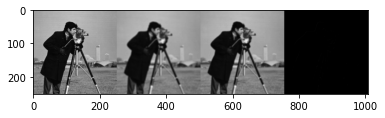

In [10]:
def box_filter_integral(img, box_width, box_height):
    box_width, box_height = box_width-1, box_height-1
    surface = max(1.0, box_width * box_height)
    integral_image = np.cumsum(np.cumsum(img, axis=0), axis=1)
    width, height = img.shape
    top_left = integral_image[0:height-box_height, 0:width-box_width]
    bottom_right = integral_image[box_height:height, box_width:width]
    top_right = integral_image[0:height-box_height, box_width:width]
    bottom_left = integral_image[box_height:height, 0:width-box_width]
    return ((top_left+bottom_right)-(top_right+bottom_left))/surface
    
# sanity_check
vectorized = box_filter_vectorized(img, 5, 5)
integral = box_filter_integral(img, 5, 5)
show([img[2:-2,2:-2], vectorized, integral, (vectorized-integral)**2])

In [20]:
integral_speeds = {}
vectorized_speeds = {}
filter_sizes = [3, 5, 7, 9, 11, 13, 15, 31, 61]
rnd_img = np.random.rand(1024,1024)
for filter_size in filter_sizes:
    integral_speeds[filter_size]=timeit.Timer(lambda: box_filter_integral(rnd_img, filter_size,filter_size)).timeit(number=1)
    vectorized_speeds[filter_size]=timeit.Timer(lambda: box_filter_vectorized(rnd_img, filter_size,filter_size)).timeit(number=1)

Text(0.5, 1.0, 'Vectorization Box-filter Speedup by filter size')

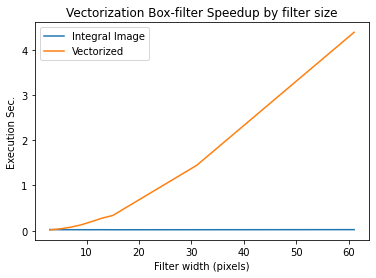

In [21]:
plt.plot(filter_sizes, [[integral_speeds[sz], vectorized_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Integral Image", "Vectorized"])
plt.title("Vectorization Box-filter Speedup by filter size")

### Overall conclusion: Faster and parallel machines are good! Big-O and Complexity is better!

Text(0.5, 1.0, 'Vectorization Box-filter Speedup by filter size')

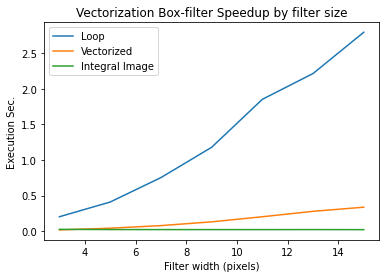

In [22]:
filter_sizes = [3, 5, 7, 9, 11, 13, 15]
plt.plot(filter_sizes, [[loop_filter_speeds[sz], vectorized_speeds[sz], integral_speeds[sz]] for sz in filter_sizes])
plt.ylabel("Execution Sec.")
plt.xlabel("Filter width (pixels)")
plt.legend(["Loop", "Vectorized", "Integral Image"])
plt.title("Vectorization Box-filter Speedup by filter size")